<a href="https://colab.research.google.com/github/manashpratim/Tweet-Classification/blob/master/Tweet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Downloading the Datasets
!wget --no-check-certificate \
      "https://datahack-prod.s3.amazonaws.com/train_file/train_E6oV3lV.csv"\
      -O "/tmp/train_tweets.csv"

!wget --no-check-certificate \
      "https://datahack-prod.s3.amazonaws.com/test_file/test_tweets_anuFYb8.csv"\
      -O "/tmp/test_tweets.csv"

--2019-07-10 02:04:27--  https://datahack-prod.s3.amazonaws.com/train_file/train_E6oV3lV.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.32
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/csv]
Saving to: ‘/tmp/train_tweets.csv’

/tmp/train_tweets.c 100%[===================>]   2.96M  1.71MB/s    in 1.7s    

2019-07-10 02:04:30 (1.71 MB/s) - ‘/tmp/train_tweets.csv’ saved [3103165/3103165]

--2019-07-10 02:04:36--  https://datahack-prod.s3.amazonaws.com/test_file/test_tweets_anuFYb8.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.0
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1635543 (1.6M) [text/csv]
Saving to: ‘/tmp/test_tweets.csv’

/tmp/test_twee

In [0]:
import numpy as np
import pandas as pd
df1=pd.read_csv('/tmp/train_tweets.csv')
df2=pd.read_csv('/tmp/test_tweets.csv')

In [3]:
df1.head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Labels Distribution:
 0    29720
1     2242
Name: label, dtype: int64


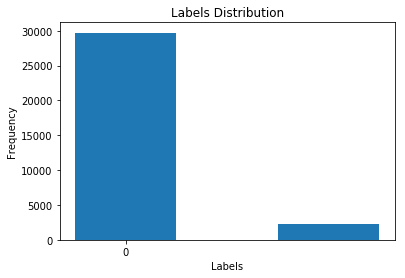

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.bar([0,1], df1['label'].value_counts(), width=0.5, bottom=None, align='center', data=df1)
plt.title('Labels Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 1, step=2))
print('Labels Distribution:\n',df1['label'].value_counts())

# **Clearly this is an imbalanced dataset.**

In [5]:
#Functions for Preprocessing the Dataset
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))


def mystopwords(text):
    return ' '.join([w for w in word_tokenize(text) if not w in stop_words])

import re
def clean_text(string):
  clean=re.sub('@[a-zA-Z0-9_]+', '', string) #removing usernames from tweets
  clean=re.sub('[\n]',' ',clean) #remove newline character
  clean=re.sub('[^a-zA-Z\']',' ',clean) #remove non alphabetic characters
  #clean=mystopwords(clean) #remove stopwords
  clean=' '.join(clean.split()) #removing unnecessary spaces
  return clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
#Cleaning the train data and separating the texts and labels
tweets=[]
labels=[]
for i in range(len(df1)):
  labels.append(df1['label'][i])
  tweets.append(clean_text(df1['tweet'][i]))
  
#Cleaning the test data 
test_tweets=[]
for i in range(len(df2)):
  test_tweets.append(clean_text(df2['tweet'][i]))


In [7]:
#Example of a tweet before and after cleaning
print('Tweet before cleaning: ',df1['tweet'][1])
print('Tweet after cleaning: ',tweets[1])

Tweet before cleaning:  @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
Tweet after cleaning:  thanks for lyft credit i can't use cause they don't offer wheelchair vans in pdx disapointed getthanked


Text(0.5, 1.0, 'Top 100 Words in the Hate Tweets')

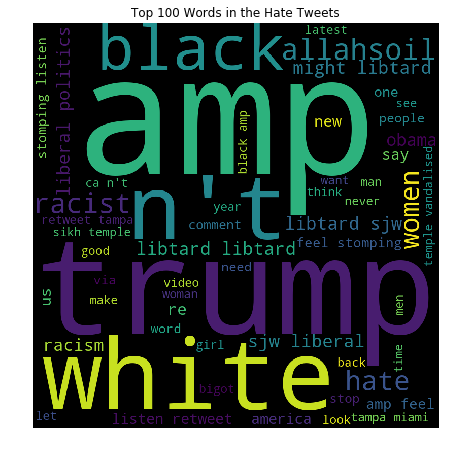

In [8]:
#Word Cloud of Top 100 Words in Hate Tweets 
from wordcloud import WordCloud, STOPWORDS  
hate=[]
for i in range(len(tweets)): #getting the hate tweets
  if labels[i]==1:
    hate.append(tweets[i])
h=' '.join(hate)  #transforming the list of hate tweets into a single sentence
h=mystopwords(h)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 20,max_words=100).generate(h)
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Top 100 Words in the Hate Tweets')

In [0]:
#Suffling the data and splitting the data into train and test sets (90:10)
from sklearn.model_selection import train_test_split
train_tweets, val_tweets, train_labels, val_labels= train_test_split(tweets, labels, test_size=0.1, shuffle= True,random_state=42)

In [10]:
#Data Summary
print('Length of the Training Set: ',len(df1))
print('No. of Training Examples: ',len(train_tweets))
print('No. of Validation Examples: ',len(val_tweets))
print('No. of Test Examples: ',len(test_tweets))

Length of the Training Set:  31962
No. of Training Examples:  28765
No. of Validation Examples:  3197
No. of Test Examples:  17197


In [11]:
#Tokenization and Padding
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


#embedding_dim = 200
max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
vocab_len=49999

tokenizer = Tokenizer(num_words=vocab_len+1,oov_token=oov_tok)
tokenizer.fit_on_texts(tweets)

word_index = tokenizer.word_index
vocab_size=len(word_index)
print('Size of Vocabulary: ',vocab_size)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_tweets)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_tweets)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_labels=np.expand_dims(train_labels, axis=1)
val_labels=np.expand_dims(val_labels, axis=1)

Size of Vocabulary:  38363


In [12]:
#Dimension of Data after Tokenizing and Padding
print('Dimension of Training Data: ',train_padded.shape)
print('Dimension of Validation Data: ',val_padded.shape)
print('Dimension of Training Labels: ',train_labels.shape)
print('Dimension of Validation Labels: ',val_labels.shape)
print('Dimension of Test Data: ',test_padded.shape)

Dimension of Training Data:  (28765, 40)
Dimension of Validation Data:  (3197, 40)
Dimension of Training Labels:  (28765, 1)
Dimension of Validation Labels:  (3197, 1)
Dimension of Test Data:  (17197, 40)


In [13]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Unzipping the fasttext pretrained model from Google Drive
import os
import zipfile

#local_zip='/content/drive/My Drive/glove.twitter.27B.zip'
local_zip='/content/drive/My Drive/crawl-300d-2M.vec.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/drive/My Drive/crawl-300d-2M.vec')
zip_ref.close()

In [0]:
# Loading the pretrained vectors
embeddings_index1 = {}
embeddings_index2 = {}
import numpy as np
with open('/content/drive/My Drive/glove.twitter.27B/glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index1[word] = coefs

with open('/content/drive/My Drive/crawl-300d-2M.vec/crawl-300d-2M.vec') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index2[word] = coefs

In [0]:
#Creating an embedding matrix that contains the vectors of the words in the dataset
embedding_dim1=200
embedding_dim2=300

embeddings_matrix1 = np.zeros((vocab_size, embedding_dim1))
for word, i in word_index.items():
    embedding_vector = embeddings_index1.get(word)
    if embedding_vector is not None:
        embeddings_matrix1[i] = embedding_vector
        
        
embeddings_matrix2 = np.zeros((vocab_size, embedding_dim2))
for word, i in word_index.items():
    embedding_vector = embeddings_index2.get(word)
    if embedding_vector is not None:
        embeddings_matrix2[i] = embedding_vector

In [16]:
print('Shape of the Embeddings Matrix (GloVe): ',embeddings_matrix1.shape)
print('Shape of the Embeddings Matrix (fastText): ',embeddings_matrix2.shape)

Shape of the Embeddings Matrix (GloVe):  (38363, 200)
Shape of the Embeddings Matrix (fastText):  (38363, 300)


## **Building the model using GloVe pretrained embeddings**

In [0]:
model1_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim1, input_length=max_length, weights = [embeddings_matrix1], trainable = False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model1_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 10
history1=model1_lstm.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Train on 28765 samples, validate on 3197 samples
Epoch 1/10
28765/28765 [==============================] - 10s 345us/sample - loss: 0.2332 - acc: 0.9225 - val_loss: 0.1417 - val_acc: 0.9456
Epoch 2/10
28765/28765 [==============================] - 8s 272us/sample - loss: 0.1585 - acc: 0.9433 - val_loss: 0.1315 - val_acc: 0.9506
Epoch 3/10
28765/28765 [==============================] - 8s 271us/sample - loss: 0.1429 - acc: 0.9489 - val_loss: 0.1474 - val_acc: 0.9415
Epoch 4/10
28765/28765 [==============================] - 8s 272us/sample - loss: 0.1359 - acc: 0.9512 - val_loss: 0.1134 - val_acc: 0.9546
Epoch 5/10
28765/28765 [==============================] - 8s 272us/sample - loss: 0.1219 - acc: 0.9571 - val_loss: 0.1128 - val_acc: 0.9571
Epoch 6/10
28765/28765 [==============================] - 8s 269us/sample - loss: 0.1216 - acc: 0.9563 - val_loss: 0.1099 - val_acc: 0.9571
Epoch 7/10
28765/28765 [==============================] - 8s 268us/sample - loss: 0.1085 - acc: 0.9607 - val_l

In [46]:
#Determining the optimal threshold value to seggregate the classes
pred1= model1_lstm.predict(val_padded, batch_size=256,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred1>thresh).astype(int))))

3197/3197 [==============================] - 1s 238us/sample
F1 score at threshold 0.1 is 0.5722713864306784
F1 score at threshold 0.11 is 0.583206106870229
F1 score at threshold 0.12 is 0.5984251968503936
F1 score at threshold 0.13 is 0.6064516129032258
F1 score at threshold 0.14 is 0.6181818181818183
F1 score at threshold 0.15 is 0.6241610738255033
F1 score at threshold 0.16 is 0.6390328151986183
F1 score at threshold 0.17 is 0.6395759717314488
F1 score at threshold 0.18 is 0.6463195691202872
F1 score at threshold 0.19 is 0.6556776556776557
F1 score at threshold 0.2 is 0.6666666666666666
F1 score at threshold 0.21 is 0.6793893129770993
F1 score at threshold 0.22 is 0.6861598440545809
F1 score at threshold 0.23 is 0.6865079365079364
F1 score at threshold 0.24 is 0.6910569105691057
F1 score at threshold 0.25 is 0.6940451745379876
F1 score at threshold 0.26 is 0.7044025157232705
F1 score at threshold 0.27 is 0.7076271186440678
F1 score at threshold 0.28 is 0.7109207708779444
F1 score at

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2984
           1       0.71      0.74      0.72       213

    accuracy                           0.96      3197
   macro avg       0.85      0.86      0.85      3197
weighted avg       0.96      0.96      0.96      3197

[[2920   64]
 [  56  157]]


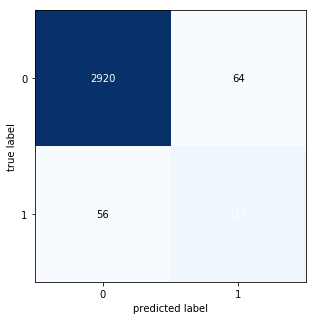

In [47]:
#From above, we can see that F1 score is highest at a threshold of 0.34
pred_val_labels1=(pred1>0.34).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels1))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels1))
CM = confusion_matrix(val_labels, pred_val_labels1)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()
  

## **Building the model using fastText pretrained embeddings**

In [0]:
model2_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim2, input_length=max_length, weights = [embeddings_matrix2], trainable = False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128,return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(128)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [54]:
reduce =tf. keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, mode='auto')
#early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')
model2_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
num_epochs = 10
history2=model2_lstm.fit(train_padded, 
                    train_labels, 
                    epochs=num_epochs, 
                    batch_size=256, 
                    validation_data=(val_padded,val_labels),
                    callbacks=[reduce],
                    verbose=1)

Train on 28765 samples, validate on 3197 samples
Epoch 1/10
28765/28765 [==============================] - 11s 372us/sample - loss: 0.2048 - acc: 0.9330 - val_loss: 0.1412 - val_acc: 0.9493
Epoch 2/10
28765/28765 [==============================] - 8s 284us/sample - loss: 0.1406 - acc: 0.9503 - val_loss: 0.1210 - val_acc: 0.9528
Epoch 3/10
28765/28765 [==============================] - 8s 284us/sample - loss: 0.1319 - acc: 0.9534 - val_loss: 0.1285 - val_acc: 0.9553
Epoch 4/10
28765/28765 [==============================] - 8s 286us/sample - loss: 0.1261 - acc: 0.9553 - val_loss: 0.1218 - val_acc: 0.9521
Epoch 5/10
28765/28765 [==============================] - 8s 285us/sample - loss: 0.1181 - acc: 0.9575 - val_loss: 0.1107 - val_acc: 0.9571
Epoch 6/10
28765/28765 [==============================] - 8s 285us/sample - loss: 0.1110 - acc: 0.9608 - val_loss: 0.1083 - val_acc: 0.9603
Epoch 7/10
28765/28765 [==============================] - 8s 287us/sample - loss: 0.1040 - acc: 0.9625 - val_l

In [67]:
#Determining the optimal threshold value to seggregate the classes
pred2= model2_lstm.predict(val_padded, batch_size=256,verbose=1)
from sklearn import metrics
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred2>thresh).astype(int))))

3197/3197 [==============================] - 0s 122us/sample
F1 score at threshold 0.1 is 0.6442687747035573
F1 score at threshold 0.11 is 0.6506024096385542
F1 score at threshold 0.12 is 0.6571428571428573
F1 score at threshold 0.13 is 0.6638655462184874
F1 score at threshold 0.14 is 0.6680942184154175
F1 score at threshold 0.15 is 0.6768558951965065
F1 score at threshold 0.16 is 0.6725663716814159
F1 score at threshold 0.17 is 0.6831460674157304
F1 score at threshold 0.18 is 0.6909090909090909
F1 score at threshold 0.19 is 0.6942528735632183
F1 score at threshold 0.2 is 0.6899766899766899
F1 score at threshold 0.21 is 0.691588785046729
F1 score at threshold 0.22 is 0.6964705882352942
F1 score at threshold 0.23 is 0.7064439140811456
F1 score at threshold 0.24 is 0.7050359712230215
F1 score at threshold 0.25 is 0.711864406779661
F1 score at threshold 0.26 is 0.7170731707317074
F1 score at threshold 0.27 is 0.7188264058679706
F1 score at threshold 0.28 is 0.7192118226600984
F1 score at 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2984
           1       0.76      0.69      0.72       213

    accuracy                           0.96      3197
   macro avg       0.87      0.83      0.85      3197
weighted avg       0.96      0.96      0.96      3197

[[2937   47]
 [  67  146]]


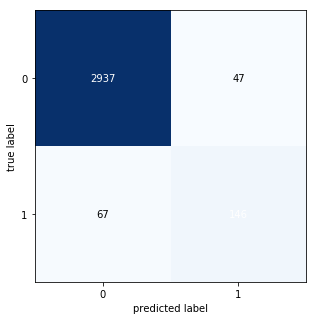

In [56]:
pred_val_labels2=(pred2>0.28).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels2))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels2))
CM = confusion_matrix(val_labels, pred_val_labels2)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()
  

##**Ensemble Model**

In [63]:
pred1_l = model1_lstm.predict(val_padded, batch_size=256,verbose=1)
pred2_l = model2_lstm.predict(val_padded, batch_size=256,verbose=1)
pred_val = 0.5*pred1_l + 0.5*pred2_l 
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_labels, (pred_val>thresh).astype(int))))

3197/3197 [==============================] - 0s 107us/sample
F1 score at threshold 0.1 is 0.6163934426229508
F1 score at threshold 0.11 is 0.6328257191201354
F1 score at threshold 0.12 is 0.6503496503496503
F1 score at threshold 0.13 is 0.6618705035971224
F1 score at threshold 0.14 is 0.6777777777777778
F1 score at threshold 0.15 is 0.6933333333333334
F1 score at threshold 0.16 is 0.7045009784735812
F1 score at threshold 0.17 is 0.7114624505928854
F1 score at threshold 0.18 is 0.7134268537074148
F1 score at threshold 0.19 is 0.7181628392484343
F1 score at threshold 0.2 is 0.7257383966244727
F1 score at threshold 0.21 is 0.7334754797441364
F1 score at threshold 0.22 is 0.7316017316017316
F1 score at threshold 0.23 is 0.7312775330396477
F1 score at threshold 0.24 is 0.7272727272727273
F1 score at threshold 0.25 is 0.7280898876404494
F1 score at threshold 0.26 is 0.7272727272727273
F1 score at threshold 0.27 is 0.7327188940092166
F1 score at threshold 0.28 is 0.7302325581395347
F1 score a

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2984
           1       0.78      0.71      0.75       213

    accuracy                           0.97      3197
   macro avg       0.88      0.85      0.86      3197
weighted avg       0.97      0.97      0.97      3197

[[2942   42]
 [  61  152]]


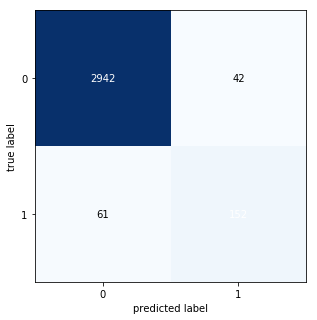

In [64]:
pred_val_labels=(pred_val>0.34).astype(int)

from sklearn.metrics import classification_report
print(classification_report(val_labels,pred_val_labels))

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print(confusion_matrix(val_labels, pred_val_labels))
CM = confusion_matrix(val_labels, pred_val_labels)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

##**Ensemble Model gives the best F1 Score**

In [66]:
pred_test1 = model1_lstm.predict(test_padded, batch_size=256,verbose=1)
pred_test2 = model2_lstm.predict(test_padded, batch_size=256,verbose=1)
pred_test = 0.5*pred_test1 + 0.5*pred_test2 
pred_test_labels = (pred_test>0.34).astype(int)
out_df = pd.DataFrame({'id':df2['id'].values})
out_df['label'] = pred_test_labels
out_df.to_csv('submission.csv', index=False)

17197/17197 [==============================] - 1s 85us/sample
